In [466]:
import numpy as np
import pandas as pd
import requests
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans
import folium
from sklearn.cluster import MiniBatchKMeans

In [211]:
conda install -c districtdatalabs yellowbrick


Solving environment: done

## Package Plan ##

  environment location: /Users/jiaxie/opt/anaconda3

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py37_0         154 KB
    conda-4.8.1                |           py37_0         2.8 MB
    pytest-runner-5.2          |             py_0          13 KB
    yellowbrick-1.0.1          |           py37_0         453 KB  districtdatalabs
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following NEW packages will be INSTALLED:

  pytest-runner      pkgs/main/noarch::pytest-runner-5.2-py_0
  yellowbrick        districtdatalabs/osx-64::yellowbrick-1.0.1-py37_0

The following packages will be UPDATED:

  conda                     conda-forge::conda-4.8.0-py37_1 --> pkgs/main::conda

In [467]:
from yellowbrick.cluster import KElbowVisualizer   #######  Yellow Brick

#### LA county website provided USPS data (ZIP_Codes_and_Postal_Cities.csv)
https://data.lacounty.gov/GIS-Data/ZIP-Codes-and-Postal-Cities/c3xr-3jw2 

In [468]:
la_zip=pd.read_csv('LA-zip-coordinate(final).csv')
print('LA zipcode data contains {} entries'.format(la_zip.shape[0]))
la_zip.head()

LA zipcode data contains 370 entries


,Unnamed: 0,zipcode,city,latitude,longitude
0,0,90713,Lakewood,33.848711,-118.113579
1,1,91306,Winnetka,34.208404,-118.575940
2,2,90002,Los Angeles,33.948951,-118.246980
3,3,90506,Torrance,33.885353,-118.326597
4,4,90069,West Hollywood,34.089403,-118.379789


#### Acquiring data from Four Square API, using the coordinate data above

In [469]:
CLIENT_ID='D013FASMP0SJ00U3KY2WDL0X3YPTDT3Y4O2D4F0G2BQFPKAM'
CLIENT_SECRET='SAU4UWB3ZM2GXWVFCTOQFFOZWPYS1LORKE1Y34RQTSY4RMDP'
VERSION= '20201010'
LIMIT=100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D013FASMP0SJ00U3KY2WDL0X3YPTDT3Y4O2D4F0G2BQFPKAM
CLIENT_SECRET:SAU4UWB3ZM2GXWVFCTOQFFOZWPYS1LORKE1Y34RQTSY4RMDP


In [ ]:
def getNearbyVenues(postcodes, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for postcode, lat, lng in zip(postcodes, latitudes, longitudes):
        #print(postcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #print (requests.get(url).json()['response'].keys())
        #print(requests.get(url).json()["response"]['groups'][0])
        
        # return only relevant information for each nearby venue
        venues_list.append([(     
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])    

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])    
 
    
    nearby_venues.columns = ['PostCode', 
                  'PostCode Latitude', 
                  'PostCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

##### Receiving the data from Four Square

In [267]:

LA_venues_L = getNearbyVenues(postcodes=la_zip['zipcode'],
                                   latitudes=la_zip['latitude'],
                                   longitudes=la_zip['longitude']
                                  )

90713


KeyError: 'groups'

In [268]:
LA_venues_L.to_csv('LA_venues(from FourSquare)-1000.csv') # saving the data to a file, just to be safe
print ('the total number of venues are **{}***'.format(LA_venues_L.shape[0]))

LA_venues_L.head()


NameError: name 'LA_venues_L' is not defined

In [470]:
#LA_venues_L[LA_venues_L.PostCode==90053]
LA=pd.read_csv('LA_venues(from FourSquare)-1000.csv')
#la_zip[la_zip.zipcode==91759]
LA[LA['Venue Category'].str.contains('Fren')].shape    # testing the data
LA

,Unnamed: 0,PostCode,PostCode Latitude,PostCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,90713,33.848711,-118.113579,California Sushi & Teriyaki,33.846888,-118.115684,Japanese Restaurant
1,1,90713,33.848711,-118.113579,Starbucks,33.846731,-118.116127,Coffee Shop
2,2,90713,33.848711,-118.113579,99 Cents Only Stores,33.847387,-118.117002,Discount Store
3,3,90713,33.848711,-118.113579,Daiso Japan,33.856183,-118.116483,Discount Store
4,4,90713,33.848711,-118.113579,Starbucks,33.856889,-118.115436,Coffee Shop
...,...,...,...,...,...,...,...,...
18457,18457,90630,33.820143,-118.039810,Evergreen Park,33.827410,-118.044899,Playground
18458,18458,91759,34.237142,-117.658018,Mt. Baldy Lodge,34.237827,-117.657747,Cocktail Bar
18459,18459,91759,34.237142,-117.658018,Mt Baldy Visitor Center,34.237767,-117.657525,Tourist Information Center
18460,18460,91759,34.237142,-117.658018,Buckhorn Lodge And Restaurant,34.237785,-117.657536,Hotel


#### From which we can see the most popular venue category is Mexican restaurant 

In [263]:
LA.groupby(['Venue Category']).count().sort_values('Venue', ascending=False).head()

,Unnamed: 0,PostCode,PostCode Latitude,PostCode Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Mexican Restaurant,796,796,796,796,796,796,796
Coffee Shop,712,712,712,712,712,712,712
Pizza Place,589,589,589,589,589,589,589
Fast Food Restaurant,542,542,542,542,542,542,542
Sandwich Place,463,463,463,463,463,463,463


##### let's see what is the most popular Mexican restaurant name. The answer is 'Chipotle Mexican Grill'

In [266]:
LA[LA['Venue Category']=='Mexican Restaurant'].groupby('Venue').count().sort_values('PostCode', ascending=False).head()

,Unnamed: 0,PostCode,PostCode Latitude,PostCode Longitude,Venue Latitude,Venue Longitude,Venue Category
Venue,,,,,,,
Chipotle Mexican Grill,66,66,66,66,66,66,66
Tocaya Organica,7,7,7,7,7,7,7
Poquito Mas,6,6,6,6,6,6,6
Don Cuco Mexican Restaurant,6,6,6,6,6,6,6
King Taco Restaurant,6,6,6,6,6,6,6


In [471]:
la_onehot=pd.get_dummies(LA['Venue Category'])
la_onehot.mean().sort_values(ascending=False)


Mexican Restaurant      0.043116
Coffee Shop             0.038566
Pizza Place             0.031903
Fast Food Restaurant    0.029358
Sandwich Place          0.025079
                          ...   
College Stadium         0.000054
Opera House             0.000054
Community Center        0.000054
Non-Profit              0.000054
Zoo                     0.000054
Length: 464, dtype: float64

In [472]:
la_onehot['zipcode']=LA['PostCode']
change_position=[la_onehot.columns[-1]]+list(la_onehot.columns[:-1])
la_onehot=la_onehot[change_position]


la_onehot.head()

,zipcode,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [271]:
la_onehot['zipcode'].sort_values().shape


(18462,)

In [272]:
la_onehot[la_onehot['zipcode'].isnull() ] .mean()

zipcode              NaN
ATM                  NaN
Accessories Store    NaN
Afghan Restaurant    NaN
African Restaurant   NaN
                      ..
Winery               NaN
Wings Joint          NaN
Women's Store        NaN
Yoga Studio          NaN
Zoo                  NaN
Length: 465, dtype: float64

In [473]:
la_onehot=la_onehot[~la_onehot['zipcode'].isnull() ] 
la_onehot

,zipcode,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,90713,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18457,90630,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18458,91759,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18459,91759,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18460,91759,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [474]:
la_grouped=la_onehot.groupby('zipcode').mean().reset_index()
la_grouped

,zipcode,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,90001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0
1,90002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047619,0.00,0.0
2,90003,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0
3,90004,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.010989,0.0,0.0,0.0,0.000000,0.00,0.0
4,90005,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.000000,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,93551,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0
357,93552,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0
358,93560,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0
359,93586,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0


In [475]:
top_venue_number=10

def return_top_venues(row, top_venue_nubmer):
    
    content=row.iloc[1:]
    content_sorted=content.sort_values(ascending=False)
    return content_sorted.index.values[:top_venue_number]

indicators=['st','nd','rd']
columns=['zipcode']

for ind in range(top_venue_number):
    try: columns.append('{}{} most frequent venue'.format(ind+1,indicators[ind]))
    
    except: columns.append('{}th most frequent venue'.format(ind+1))
la_sorted=pd.DataFrame()
#print(Toronto_sorted)
la_sorted=pd.DataFrame(columns=columns)
la_sorted['zipcode']=la_grouped['zipcode']
    
print(len(la_grouped.zipcode))
    
for ind in np.arange(len(la_sorted.zipcode)):
    la_sorted.iloc[ind,1:]=return_top_venues(la_grouped.iloc[ind,:], top_venue_number)
  #  print(Toronto_sorted.iloc[ind,:])
    
la_sorted.head()


361


,zipcode,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
0,90001,Burger Joint,Mexican Restaurant,Pharmacy,Bank,Construction & Landscaping,Playground,Pizza Place,Pet Store,Sandwich Place,Seafood Restaurant
1,90002,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Mobile Phone Shop,Grocery Store,Video Store,Pharmacy,Park,Sandwich Place,Basketball Court
2,90003,Chinese Restaurant,Fried Chicken Joint,ATM,Grocery Store,Print Shop,Pizza Place,Sandwich Place,Coffee Shop,Donut Shop,Shoe Store
3,90004,Korean Restaurant,Thai Restaurant,Coffee Shop,Food Truck,Bakery,Bar,Seafood Restaurant,Sandwich Place,Convenience Store,Pizza Place
4,90005,Korean Restaurant,Café,Bakery,Ice Cream Shop,Japanese Restaurant,BBQ Joint,Mexican Restaurant,Sushi Restaurant,Coffee Shop,Restaurant


#### Determining the proper K, so we can use KMeans to categorize the zipcodes

In [477]:
grouped_drop=la_grouped.drop(['zipcode'],axis=1)


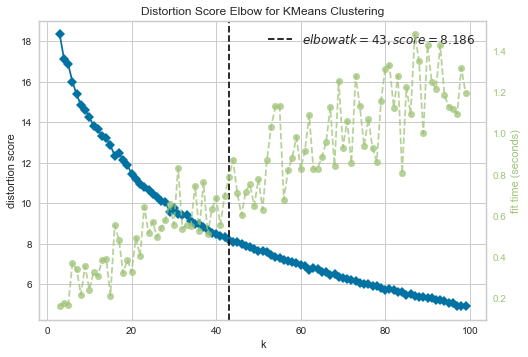

In [478]:

model=KMeans()
visualizer= KElbowVisualizer(model, k=(3,100))
visualizer.fit(grouped_drop)
visualizer.show()

#### From above we can see that there is no real "elbow", so I choose to use 10 as k value
#### K Means fit

In [479]:
cluster_number=10
kmeans=KMeans(n_clusters=cluster_number, random_state=0).fit(grouped_drop)
kmeans.labels_[0:50]

array([6, 1, 1, 9, 7, 7, 9, 1, 9, 7, 6, 9, 9, 9, 9, 1, 9, 1, 9, 7, 9, 6,
       6, 9, 9, 9, 9, 9, 9, 6, 6, 6, 9, 9, 9, 1, 9, 9, 1, 9, 9, 1, 1, 9,
       9, 1, 9, 9, 9, 1], dtype=int32)

In [480]:
la_sorted.insert(0,'labels',kmeans.labels_)
la_sorted.head()

,labels,zipcode,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
0,6,90001,Burger Joint,Mexican Restaurant,Pharmacy,Bank,Construction & Landscaping,Playground,Pizza Place,Pet Store,Sandwich Place,Seafood Restaurant
1,1,90002,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Mobile Phone Shop,Grocery Store,Video Store,Pharmacy,Park,Sandwich Place,Basketball Court
2,1,90003,Chinese Restaurant,Fried Chicken Joint,ATM,Grocery Store,Print Shop,Pizza Place,Sandwich Place,Coffee Shop,Donut Shop,Shoe Store
3,9,90004,Korean Restaurant,Thai Restaurant,Coffee Shop,Food Truck,Bakery,Bar,Seafood Restaurant,Sandwich Place,Convenience Store,Pizza Place
4,7,90005,Korean Restaurant,Café,Bakery,Ice Cream Shop,Japanese Restaurant,BBQ Joint,Mexican Restaurant,Sushi Restaurant,Coffee Shop,Restaurant


In [481]:
la_cluster=la_zip.join(la_sorted.set_index('zipcode'), on='zipcode').reset_index().drop(['index','Unnamed: 0'],axis=1)
la_cluster=la_cluster[~la_cluster.labels.isnull()]

In [482]:
la_cluster.labels=la_cluster.labels.astype(int)
la_cluster

,zipcode,city,latitude,longitude,labels,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
0,90713,Lakewood,33.848711,-118.113579,1,Cosmetics Shop,Fast Food Restaurant,Discount Store,Convenience Store,Smoke Shop,Coffee Shop,Japanese Restaurant,Video Store,Flower Shop,Supermarket
1,91306,Winnetka,34.208404,-118.575940,6,Pizza Place,Mexican Restaurant,Convenience Store,Video Store,Grocery Store,Italian Restaurant,Latin American Restaurant,Pharmacy,Fried Chicken Joint,Sandwich Place
2,90002,Los Angeles,33.948951,-118.246980,1,Fast Food Restaurant,Food Truck,Fried Chicken Joint,Mobile Phone Shop,Grocery Store,Video Store,Pharmacy,Park,Sandwich Place,Basketball Court
3,90506,Torrance,33.885353,-118.326597,1,Fast Food Restaurant,Mexican Restaurant,Coffee Shop,Donut Shop,Pizza Place,Mediterranean Restaurant,Flea Market,Sushi Restaurant,Italian Restaurant,Sandwich Place
4,90069,West Hollywood,34.089403,-118.379789,9,Hotel,Sushi Restaurant,Gym,Burger Joint,New American Restaurant,Gay Bar,Salad Place,Coffee Shop,French Restaurant,Gym / Fitness Center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,90011,Los Angeles,34.007904,-118.259037,6,Fast Food Restaurant,Mexican Restaurant,Seafood Restaurant,Park,Ice Cream Shop,Café,Fried Chicken Joint,Grocery Store,Latin American Restaurant,Kitchen Supply Store
366,90247,Gardena,33.891892,-118.298498,9,Bubble Tea Shop,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Thai Restaurant,Bakery,Café,Chinese Restaurant,Bank,Noodle House
367,90601,Whittier,33.995473,-118.040466,0,Trail,Food,Convenience Store,Zoo,Factory,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
368,90630,Cypress,33.820143,-118.039810,9,Pharmacy,Baseball Field,American Restaurant,Arcade,Tennis Court,Big Box Store,Liquor Store,Gym,Park,Pet Store


### The map is here

In [327]:
# create map
a=la_cluster.latitude.mean()
b=la_cluster.longitude.mean()
map_cluster=folium.Map   (location=[a,b], zoom_start=12)


# set color scheme for the clusters
x = np.arange(cluster_number)
ys = [i + x + (i*x)**2 for i in range(cluster_number)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_cluster['latitude'], la_cluster['longitude'], la_cluster['zipcode'], la_cluster['labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster)
       
map_cluster

In [483]:
la_cluster[la_cluster.labels==6].head()

,zipcode,city,latitude,longitude,labels,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
1,91306,Winnetka,34.208404,-118.575940,6,Pizza Place,Mexican Restaurant,Convenience Store,Video Store,Grocery Store,Italian Restaurant,Latin American Restaurant,Pharmacy,Fried Chicken Joint,Sandwich Place
8,91702,Azusa,34.127122,-117.906209,6,Mexican Restaurant,Convenience Store,Fast Food Restaurant,Bank,Park,Coffee Shop,Hotel,Grocery Store,Liquor Store,Gastropub
23,91724,Covina,34.091232,-117.858336,6,Park,Pizza Place,Liquor Store,Coffee Shop,Tree,Mexican Restaurant,Video Store,Film Studio,Event Service,Dumpling Restaurant
35,90033,Los Angeles,34.048564,-118.211520,6,Mexican Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant,Burger Joint,Bookstore,Grocery Store,Fried Chicken Joint,Sandwich Place,Convenience Store
40,91008,Duarte,34.148373,-117.965966,6,Bar,Business Service,Sushi Restaurant,American Restaurant,Mexican Restaurant,Convenience Store,English Restaurant,Entertainment Service,Empanada Restaurant,Farm


In [487]:
the_list=la_cluster[la_cluster.labels==6]
the_list.to_csv('Mexican_restaurant_list.csv')
the_list

,zipcode,city,latitude,longitude,labels,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
1,91306,Winnetka,34.208404,-118.575940,6,Pizza Place,Mexican Restaurant,Convenience Store,Video Store,Grocery Store,Italian Restaurant,Latin American Restaurant,Pharmacy,Fried Chicken Joint,Sandwich Place
8,91702,Azusa,34.127122,-117.906209,6,Mexican Restaurant,Convenience Store,Fast Food Restaurant,Bank,Park,Coffee Shop,Hotel,Grocery Store,Liquor Store,Gastropub
23,91724,Covina,34.091232,-117.858336,6,Park,Pizza Place,Liquor Store,Coffee Shop,Tree,Mexican Restaurant,Video Store,Film Studio,Event Service,Dumpling Restaurant
35,90033,Los Angeles,34.048564,-118.211520,6,Mexican Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant,Burger Joint,Bookstore,Grocery Store,Fried Chicken Joint,Sandwich Place,Convenience Store
40,91008,Duarte,34.148373,-117.965966,6,Bar,Business Service,Sushi Restaurant,American Restaurant,Mexican Restaurant,Convenience Store,English Restaurant,Entertainment Service,Empanada Restaurant,Farm
41,90304,Inglewood,33.939383,-118.358129,6,Mexican Restaurant,Hotel,Pizza Place,Taco Place,Rental Car Location,Fast Food Restaurant,Liquor Store,Convenience Store,Latin American Restaurant,Burger Joint
42,90660,Pico Rivera,33.991332,-118.091237,6,Mexican Restaurant,Steakhouse,Playground,Chinese Restaurant,Bakery,Automotive Shop,Sandwich Place,Pharmacy,Arcade,Gym / Fitness Center
46,90031,Los Angeles,34.077524,-118.213106,6,Mexican Restaurant,Fast Food Restaurant,Taco Place,Pharmacy,Coffee Shop,Sandwich Place,Thrift / Vintage Store,Convenience Store,Music Venue,Seafood Restaurant
52,90301,Inglewood,33.956363,-118.354849,6,Mexican Restaurant,Liquor Store,Southern / Soul Food Restaurant,Grocery Store,Fast Food Restaurant,Coffee Shop,Convenience Store,Pizza Place,Bank,Basketball Court
53,91766,Pomona,34.044180,-117.752396,6,Mexican Restaurant,Shoe Store,Pizza Place,Fast Food Restaurant,Mobile Phone Shop,Donut Shop,Pharmacy,Food,Hotel,Currency Exchange



#### SELECTED CHARACTERISTICS OF THE TOTAL AND NATIVE POPULATIONS IN LA(from US census)
##### This was achieved by selecting all the zipcode in LA county
https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t 

##### Origianlly the csv file contains more than 450 columns. The desired parameters were manually selected and saved to 'column_list_reduced57.csv' and 'column_list_reduced53.csv' (note that the column names are slightly different across the years data)

In [308]:
column_list=pd.read_csv('column_list_reduced57.csv')
column_list.columns=['ID','description','example_value']
column_list
the_list57=column_list.ID.to_list()


column_list=pd.read_csv('column_list_reduced53.csv')
column_list.columns=['ID','description','example_value']
column_list
the_list53=column_list.ID.to_list()

##### Loading the data 

In [310]:
data_11=pd.read_csv('ACS_11_5YR_S0601 .csv')[the_list57]
data_12=pd.read_csv('ACS_12_5YR_S0601 .csv') [the_list57]
data_13=pd.read_csv('ACS_13_5YR_S0601 .csv')[the_list53]
data_14=pd.read_csv('ACS_14_5YR_S0601 .csv') [the_list53]
data_15=pd.read_csv('ACS_15_5YR_S0601 .csv') [the_list53]
data_16=pd.read_csv('ACS_16_5YR_S0601.csv') [the_list53]
data_17=pd.read_csv('ACS_17_5YR_S0601.csv') [the_list53]
data_17.head()

,GEO.id2,HC01_EST_VC01,HC01_EST_VC06,HC01_EST_VC12,HC01_EST_VC28,HC01_EST_VC53
0,Id2,Total; Estimate; Total population,Total; Estimate; AGE - 25 to 44 years,Total; Estimate; Median age (years),Total; Estimate; Hispanic or Latino origin (of...,Total; Estimate; INDIVIDUALS' INCOME IN THE PA...
1,90001,58738,29.4,28.7,89.8,43308
2,90002,52856,28.4,27.7,76.4,38941
3,90003,70490,29,28.2,76.8,51562
4,90004,62733,36.8,35.1,51.4,52581


In [311]:
data_17_1=data_17[~(data_17.HC01_EST_VC01=='0')].reset_index()
print (data_17_1.shape)
key_points=['HC01_EST_VC01','HC01_EST_VC06','HC01_EST_VC12','HC01_EST_VC28','HC01_EST_VC53']
data_17_key=data_17_1[key_points].iloc[1:,:].astype('float')
#data_11_key=data_11_key1.astype('float')
data_17_key.insert(0,'GEO.id',data_17_1['GEO.id2'])
data_17_key.shape
#data_17['GEO.id2'].isin(['93536'])
#len(data_17['GEO.id2'])
#data_17[data_17['GEO.id2'].isin(['93536'])]
data_17_key

(282, 7)


,GEO.id,HC01_EST_VC01,HC01_EST_VC06,HC01_EST_VC12,HC01_EST_VC28,HC01_EST_VC53
1,90001,58738.0,29.4,28.7,89.8,43308.0
2,90002,52856.0,28.4,27.7,76.4,38941.0
3,90003,70490.0,29.0,28.2,76.8,51562.0
4,90004,62733.0,36.8,35.1,51.4,52581.0
5,90005,39562.0,38.4,35.4,49.5,32905.0
...,...,...,...,...,...,...
277,93551,51896.0,23.9,37.6,33.0,40674.0
278,93552,41320.0,25.4,29.8,70.0,30187.0
279,93553,1893.0,16.9,52.4,33.0,1745.0
280,93563,417.0,24.2,48.9,17.0,402.0


In [312]:
def subset_57 (data):
    tem=data[~(data.HC01_EST_VC01=='0')].reset_index()
    key_points=['HC01_EST_VC01','HC01_EST_VC06','HC01_EST_VC12','HC01_EST_VC28','HC01_EST_VC57']
    tem_key=tem[key_points].iloc[1:,:].astype('float')
    tem_key.insert(0,'GEO.id',tem['GEO.id2'])
    tem_key.columns= ['Zipcode',"Total population", "AGE-25 to 44 years", "Median age(years)", "Hispanic or Latino origin", "INDIVIDUALS' INCOME"]
    return tem_key

def subset_53 (data):
    tem=data[~(data.HC01_EST_VC01=='0')].reset_index()
    key_points=['HC01_EST_VC01','HC01_EST_VC06','HC01_EST_VC12','HC01_EST_VC28','HC01_EST_VC53']
    tem_key=tem[key_points].iloc[1:,:].astype('float')
    tem_key.insert(0,'GEO.id',tem['GEO.id2'])
    tem_key.columns= ['Zipcode',"Total population", "AGE-25 to 44 years", "Median age(years)", "Hispanic or Latino origin", "INDIVIDUALS' INCOME"]
    return tem_key

data_11_new=subset_57(data_11)
data_11_new

,Zipcode,Total population,AGE-25 to 44 years,Median age(years),Hispanic or Latino origin,INDIVIDUALS' INCOME
1,90001,54760.0,31.0,26.6,90.1,39651.0
2,90002,46509.0,27.2,25.2,71.5,32390.0
3,90003,66183.0,28.1,25.7,72.9,46319.0
4,90004,63932.0,35.4,34.9,50.9,53034.0
5,90005,41178.0,38.8,33.7,54.5,33740.0
...,...,...,...,...,...,...
277,93551,49896.0,22.9,36.1,30.3,38007.0
278,93552,38178.0,26.3,26.7,61.1,27790.0
279,93553,2130.0,27.0,44.0,21.3,1904.0
280,93563,353.0,21.5,53.2,21.8,353.0


In [314]:
aa=list(data_17_key['GEO.id'])
for i in np.arange (len(data_17_key['GEO.id'])):
    data_17_key['GEO.id'][i+1]='zip-'+data_17_key['GEO.id'][i+1]
    #print(data_17_key['GEO.id'][i+1])
print(len(data_17_key['GEO.id']))
print(list(data_17_key['GEO.id']))
data_17_key.shape
#type(aa)
#data_17_key

281
['zip-90001', 'zip-90002', 'zip-90003', 'zip-90004', 'zip-90005', 'zip-90006', 'zip-90007', 'zip-90008', 'zip-90010', 'zip-90011', 'zip-90012', 'zip-90013', 'zip-90014', 'zip-90015', 'zip-90016', 'zip-90017', 'zip-90018', 'zip-90019', 'zip-90020', 'zip-90021', 'zip-90022', 'zip-90023', 'zip-90024', 'zip-90025', 'zip-90026', 'zip-90027', 'zip-90028', 'zip-90029', 'zip-90031', 'zip-90032', 'zip-90033', 'zip-90034', 'zip-90035', 'zip-90036', 'zip-90037', 'zip-90038', 'zip-90039', 'zip-90040', 'zip-90041', 'zip-90042', 'zip-90043', 'zip-90044', 'zip-90045', 'zip-90046', 'zip-90047', 'zip-90048', 'zip-90049', 'zip-90056', 'zip-90057', 'zip-90058', 'zip-90059', 'zip-90061', 'zip-90062', 'zip-90063', 'zip-90064', 'zip-90065', 'zip-90066', 'zip-90067', 'zip-90068', 'zip-90069', 'zip-90073', 'zip-90077', 'zip-90089', 'zip-90094', 'zip-90201', 'zip-90210', 'zip-90211', 'zip-90212', 'zip-90220', 'zip-90221', 'zip-90222', 'zip-90230', 'zip-90232', 'zip-90240', 'zip-90241', 'zip-90242', 'zip-90

/Users/jiaxie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(281, 6)

In [315]:
data_17_key.columns= ['Zipcode',"Total population", "AGE-25 to 44 years", "Median age(years)", "Hispanic or Latino origin", "INDIVIDUALS' INCOME"]


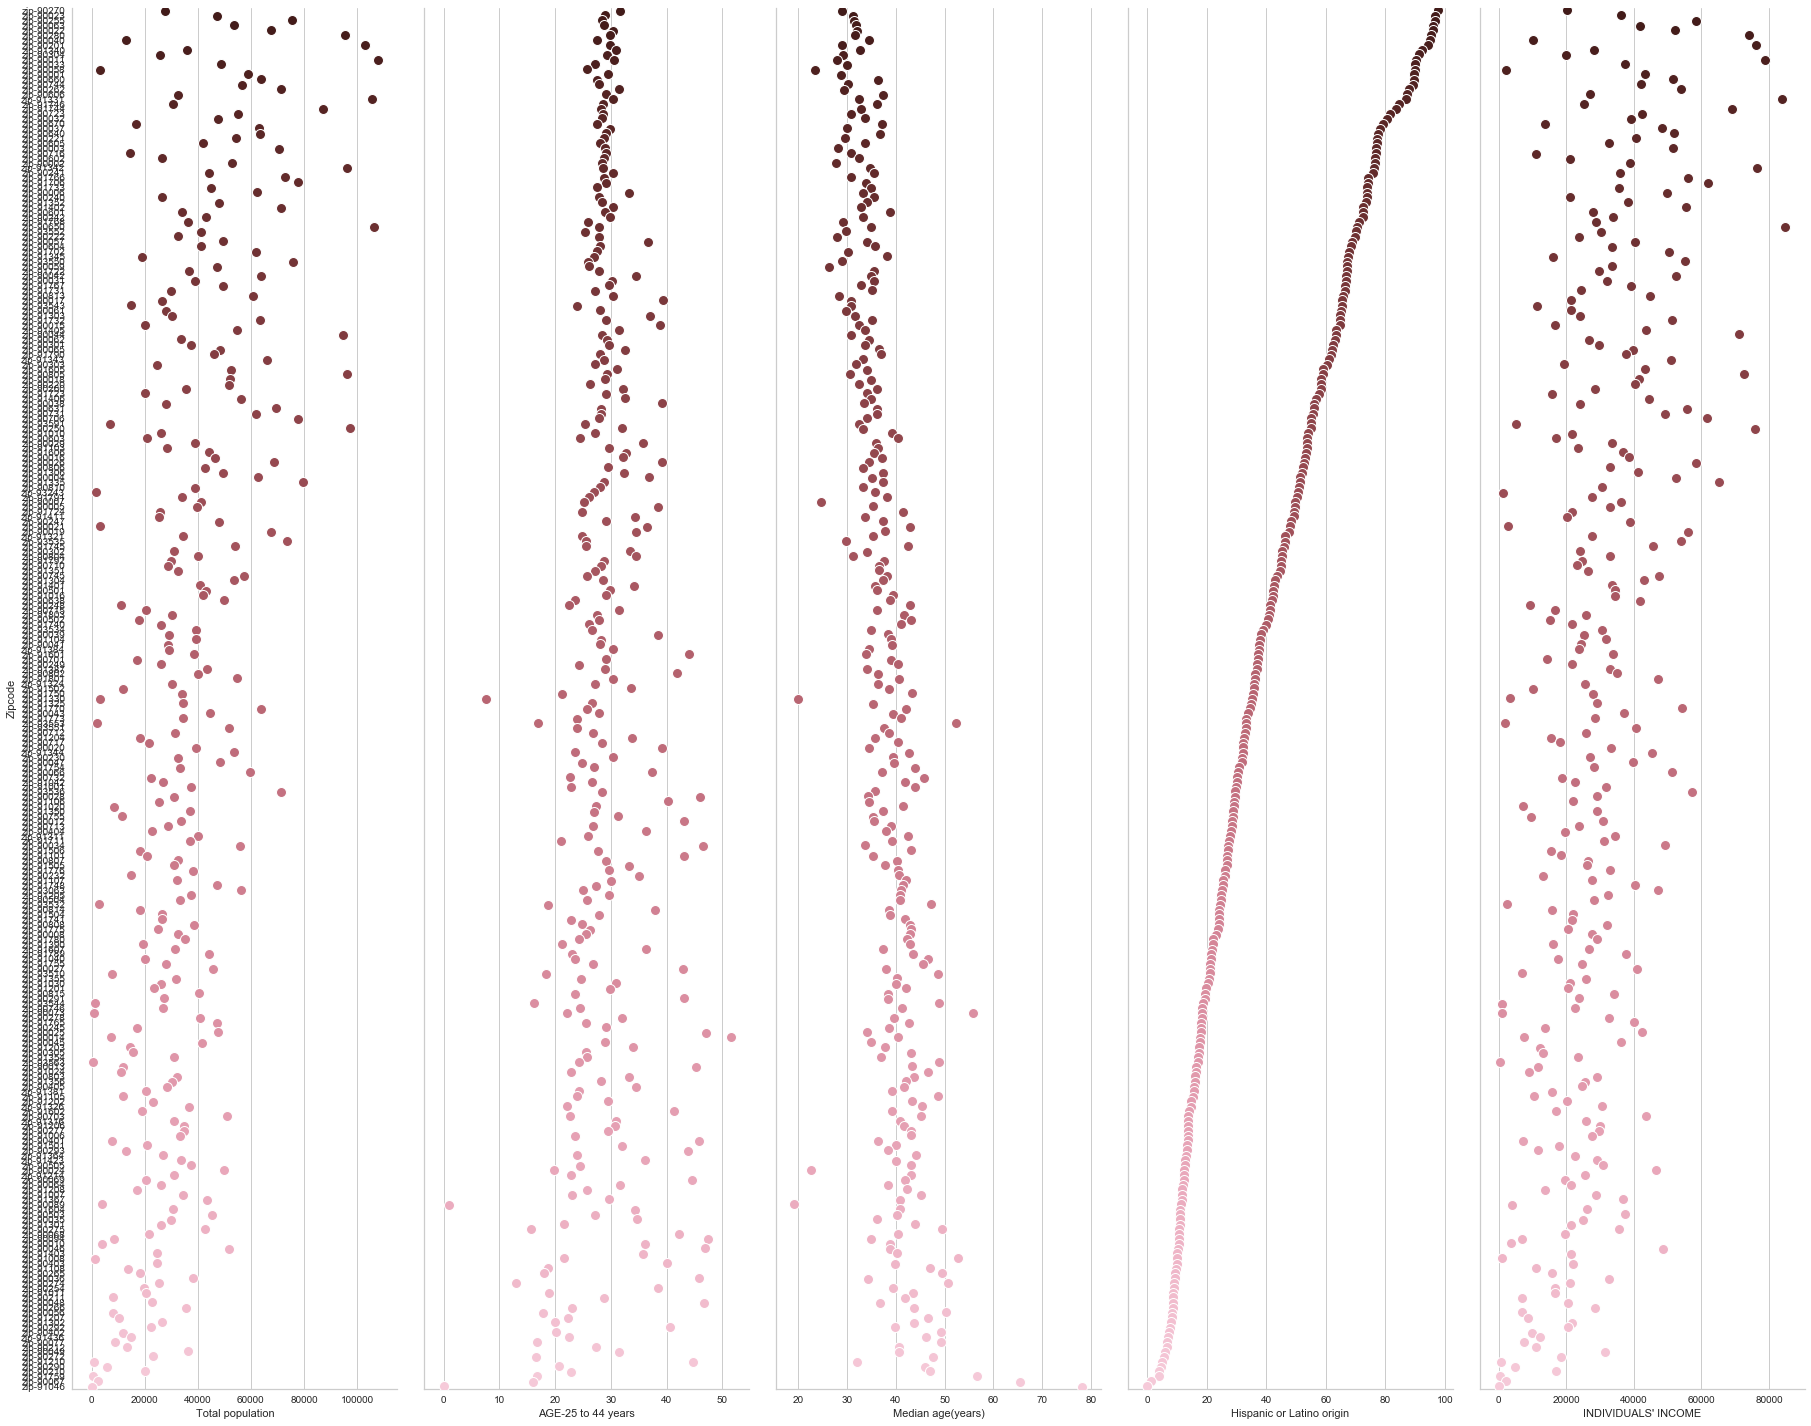

In [316]:
g = sns.PairGrid(data_17_key.sort_values('Hispanic or Latino origin', ascending=False), x_vars=data_17_key.columns[1:], y_vars=['Zipcode'], height=20, aspect=.25)

 
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")


In [317]:
data_17_key

,Zipcode,Total population,AGE-25 to 44 years,Median age(years),Hispanic or Latino origin,INDIVIDUALS' INCOME
1,zip-90001,58738.0,29.4,28.7,89.8,43308.0
2,zip-90002,52856.0,28.4,27.7,76.4,38941.0
3,zip-90003,70490.0,29.0,28.2,76.8,51562.0
4,zip-90004,62733.0,36.8,35.1,51.4,52581.0
5,zip-90005,39562.0,38.4,35.4,49.5,32905.0
...,...,...,...,...,...,...
277,zip-93551,51896.0,23.9,37.6,33.0,40674.0
278,zip-93552,41320.0,25.4,29.8,70.0,30187.0
279,zip-93553,1893.0,16.9,52.4,33.0,1745.0
280,zip-93563,417.0,24.2,48.9,17.0,402.0


In [318]:
data_12_new=subset_57(data_12)
data_13_new=subset_53(data_13)
data_14_new=subset_53(data_14)
data_15_new=subset_53(data_15)
data_16_new=subset_53(data_16)
data_17_new=subset_53(data_17)

data_13_new

,Zipcode,Total population,AGE-25 to 44 years,Median age(years),Hispanic or Latino origin,INDIVIDUALS' INCOME
1,90001,54760.0,29.8,27.0,90.5,39668.0
2,90002,49475.0,27.6,25.8,72.7,34903.0
3,90003,66200.0,27.9,26.2,73.1,46773.0
4,90004,62760.0,34.1,35.8,51.4,52273.0
5,90005,39548.0,37.6,33.8,54.6,32508.0
...,...,...,...,...,...,...
277,93551,50306.0,23.0,37.9,32.2,39640.0
278,93552,39943.0,24.8,27.7,62.2,29024.0
279,93553,2242.0,22.5,47.8,23.0,2035.0
280,93563,344.0,21.8,55.7,28.2,344.0


In [422]:
data_17_high=data_17_new[data_17_new['Hispanic or Latino origin']>75.0]
data_17_high.shape

(34, 6)

##### a 3D plot to show what pattern the data looks like

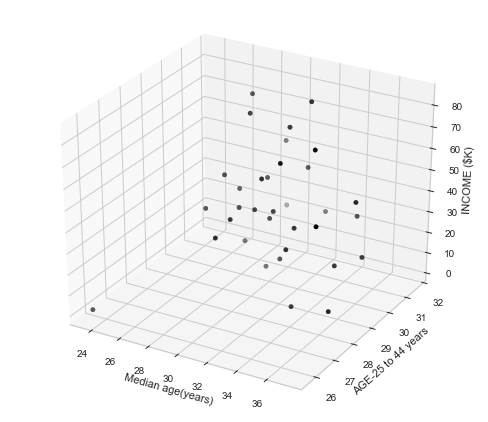

In [400]:

y, x, z = data_17_high['AGE-25 to 44 years'], data_17_high['Median age(years)'], data_17_high["INDIVIDUALS' INCOME"]/1000
ax = plt.subplot(1,1,1, projection='3d' )  # creating a 3D project
 
fig = plt.gcf()
fig.set_size_inches(8.5, 7.5)
 
ax.scatter(x[:], y[:], z[:], c='black' )  

ax.set_zlabel("INCOME ($K)")  
ax.set_ylabel('AGE-25 to 44 years')
ax.set_xlabel('Median age(years)')

plt.show() 

### Looks like the Y axis, which is 'AGE-25 to 44 years', has larger impact on income

#### Finding the zipcodes that are both in the above found cluster 6 group and high in Hispanic or Latino origin

In [433]:
the_list1=the_list.rename(columns={'zipcode':'Zipcode'})

In [425]:
the_list.zipcode=the_list.zipcode.astype(str)
type(list(the_list.zipcode.astype(str))[0])

str

In [434]:
type(list(data_17_high.Zipcode)[0])
type(list(data_17_high.Zipcode)[0])
the_list1.head()

,Zipcode,city,latitude,longitude,labels,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
1,91306,Winnetka,34.208404,-118.575940,6,Pizza Place,Mexican Restaurant,Convenience Store,Video Store,Grocery Store,Italian Restaurant,Latin American Restaurant,Pharmacy,Fried Chicken Joint,Sandwich Place
8,91702,Azusa,34.127122,-117.906209,6,Mexican Restaurant,Convenience Store,Fast Food Restaurant,Bank,Park,Coffee Shop,Hotel,Grocery Store,Liquor Store,Gastropub
23,91724,Covina,34.091232,-117.858336,6,Park,Pizza Place,Liquor Store,Coffee Shop,Tree,Mexican Restaurant,Video Store,Film Studio,Event Service,Dumpling Restaurant
35,90033,Los Angeles,34.048564,-118.211520,6,Mexican Restaurant,Fast Food Restaurant,Bakery,Seafood Restaurant,Burger Joint,Bookstore,Grocery Store,Fried Chicken Joint,Sandwich Place,Convenience Store
40,91008,Duarte,34.148373,-117.965966,6,Bar,Business Service,Sushi Restaurant,American Restaurant,Mexican Restaurant,Convenience Store,English Restaurant,Entertainment Service,Empanada Restaurant,Farm


In [435]:
data_17_high1=pd.merge(data_17_high, the_list1, how='inner', on='Zipcode')

In [436]:
data_17_high1.shape

(22, 20)

### Getting the relatively highest groups with 'AGE-25 to 44 years'

In [440]:
data_17_top=data_17_high1.sort_values('AGE-25 to 44 years', ascending=False).head(6)
 
data_11_top=data_11_new[data_11_new['Zipcode'].isin(data_17_top['Zipcode'])]
data_12_top=data_12_new[data_12_new['Zipcode'].isin(data_17_top['Zipcode'])]
data_13_top=data_13_new[data_13_new['Zipcode'].isin(data_17_top['Zipcode'])]
data_14_top=data_14_new[data_14_new['Zipcode'].isin(data_17_top['Zipcode'])]
data_15_top=data_15_new[data_15_new['Zipcode'].isin(data_17_top['Zipcode'])]
data_16_top=data_16_new[data_16_new['Zipcode'].isin(data_17_top['Zipcode'])]

data_11_top=data_11_top.reset_index().drop('index',axis=1)
data_12_top=data_12_top.reset_index().drop('index',axis=1)
data_13_top=data_13_top.reset_index().drop('index',axis=1)
data_14_top=data_14_top.reset_index().drop('index',axis=1)
data_15_top=data_15_top.reset_index().drop('index',axis=1)
data_16_top=data_16_top.reset_index().drop('index',axis=1)
data_17_top=data_17_top.sort_values('Zipcode').reset_index().drop('index',axis=1)

data_17_top

,Zipcode,Total population,AGE-25 to 44 years,Median age(years),Hispanic or Latino origin,INDIVIDUALS' INCOME,city,latitude,longitude,labels,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
0,90011,108051.0,30.6,28.0,90.2,78870.0,Los Angeles,34.007904,-118.259037,6,Fast Food Restaurant,Mexican Restaurant,Seafood Restaurant,Park,Ice Cream Shop,Café,Fried Chicken Joint,Grocery Store,Latin American Restaurant,Kitchen Supply Store
1,90022,67446.0,30.4,32.1,95.9,52258.0,Los Angeles,34.023581,-118.155117,6,Mexican Restaurant,Fast Food Restaurant,Food Truck,Pizza Place,Convenience Store,Mobile Phone Shop,Pharmacy,Bank,Video Game Store,Discount Store
2,90262,71306.0,31.4,29.3,88.0,54061.0,Lynwood,33.925123,-118.203199,6,Fast Food Restaurant,Mexican Restaurant,Convenience Store,Burger Joint,Taco Place,Pharmacy,Pizza Place,ATM,Laundromat,Park
3,90270,27597.0,31.7,29.0,97.7,20321.0,Maywood,33.988503,-118.188948,6,Mexican Restaurant,Convenience Store,Pizza Place,Fast Food Restaurant,Discount Store,Burger Joint,Gas Station,Fried Chicken Joint,Grocery Store,Park
4,91331,105696.0,30.3,32.4,86.9,83692.0,Pacoima,34.257264,-118.419820,6,Mexican Restaurant,Burger Joint,Business Service,Thai Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Supermarket,Spa,Taco Place,Airport
5,91340,35771.0,31.0,32.6,92.2,28064.0,San Fernando,34.286193,-118.437447,6,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Bank,Frozen Yogurt Shop,Diner,Breakfast Spot,Seafood Restaurant,Burger Joint,Mobile Phone Shop


In [441]:
the_list=[data_11_top,data_12_top,data_13_top,data_14_top,data_15_top, data_16_top,data_17_top]
#print(the_list[6])

years=pd.Series([2011,2012,2013,2014,2015,2016,2017])

def extraction (i):
    new_df=pd.DataFrame(columns=data_17_top.columns)
    
    for n in range(len(the_list)):
        new_df=new_df.append(the_list[n].iloc[i,:],ignore_index=True)
        #print(the_list[n].iloc[i,:])
    new_df.insert(0,'years',years)
    return(new_df)

data_0=extraction(0)
data_1=extraction(1)
data_2=extraction(2)
data_3=extraction(3)
data_4=extraction(4)
data_5=extraction(5)

data_5


,years,Zipcode,Total population,AGE-25 to 44 years,Median age(years),Hispanic or Latino origin,INDIVIDUALS' INCOME,city,latitude,longitude,...,1st most frequent venue,2nd most frequent venue,3rd most frequent venue,4th most frequent venue,5th most frequent venue,6th most frequent venue,7th most frequent venue,8th most frequent venue,9th most frequent venue,10th most frequent venue
0,2011,91340,34516.0,28.3,28.4,91.0,25681.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012,91340,35207.0,29.4,29.3,91.1,25903.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,91340,35161.0,30.2,31.3,88.6,26533.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,91340,35455.0,31.7,31.4,90.2,26945.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,91340,35481.0,32.3,31.5,90.6,27289.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016,91340,35681.0,31.8,31.6,91.5,27644.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2017,91340,35771.0,31.0,32.6,92.2,28064.0,San Fernando,34.286193,-118.437447,...,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Bank,Frozen Yogurt Shop,Diner,Breakfast Spot,Seafood Restaurant,Burger Joint,Mobile Phone Shop


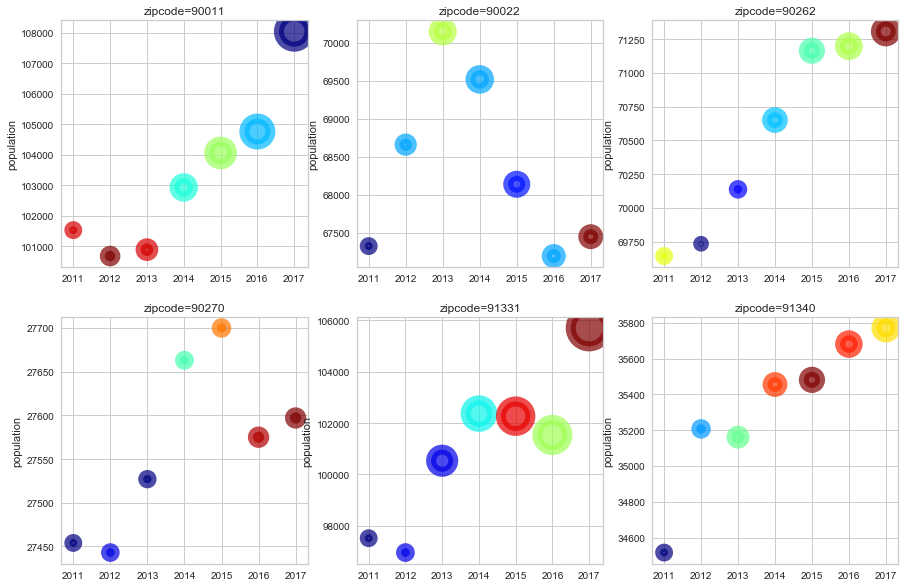

In [465]:
data=[data_0,data_1,data_2,data_3,data_4,data_5]
fig=plt.figure(figsize=(15,10))


def picuture (data):
    
    for n in range(len(data)):
        ax=fig.add_subplot(2,3,n+1)
        ax.scatter(data=data[n], x=data[n].years, y='Total population',cmap=plt.cm.jet,linewidths=10, alpha=0.7,  c='AGE-25 to 44 years', s=(data[n]["INDIVIDUALS' INCOME"]-data[n]["INDIVIDUALS' INCOME"][0]+500)/8)
        ax.set_title('zipcode={}'.format(data[n]['Zipcode'][0]))
        #ax.set_ylim(2500,4000)
        ax.set_ylabel("population")


picuture(data)
